# Complete Data Processing Pipeline for Alloy Property Data
This notebook provides a comprehensive pipeline for processing alloy formula property data, including dimensionality reduction using PCA.

# 1. Import Libraries and Setup

In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print(f"Pipeline started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Pipeline started at: 2025-09-20 22:41:54


# 2. Load and Inspect Data


In [189]:
# Load the original dataset
data_path = './al_data.csv'
data = pd.read_csv(data_path)
# rename the first column to "FID"
data = data.rename(columns={data.columns[0]: 'FID'})
print(f"Original dataset shape: {data.shape}")
print(f"Columns: {data.columns.tolist()[:10]}...") # Show first 10 columns
print(f"\nData types:")
print(data.dtypes.value_counts())
print(f"\nMissing values: {data.isnull().sum().sum()}")

# Display basic info
data.info()

Original dataset shape: (1154, 31)
Columns: ['FID', 'Processing', 'Ag', 'Al', 'B', 'Be', 'Bi', 'Cd', 'Co', 'Cr']...

Data types:
float64    28
object      2
int64       1
Name: count, dtype: int64

Missing values: 250
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154 entries, 0 to 1153
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   FID                     1154 non-null   int64  
 1   Processing              1154 non-null   object 
 2   Ag                      1154 non-null   float64
 3   Al                      1154 non-null   float64
 4   B                       1154 non-null   float64
 5   Be                      1154 non-null   float64
 6   Bi                      1154 non-null   float64
 7   Cd                      1154 non-null   float64
 8   Co                      1154 non-null   float64
 9   Cr                      1154 non-null   float64
 10  Cu                      1154 non-n

# 3. Initial Data Processing


In [190]:
# Parse formula codes to extract metadata
print("Processing alloy processing...")
# categoryize column ‘Processing' to be one-hot encoding, each category named as "Condition_(Number)"

if 'Processing' in data.columns:
    data['Processing'] = data['Processing'].astype(str).str.strip()
    processing_dummies = pd.get_dummies(data['Processing'])
    # print each category
    print(f"Processing categories: {processing_dummies.columns.tolist()}")
    # reename columns to be "Condition_1", "Condition_2", ...
    processing_dummies.columns = [f'Condition_{i+1}' for i in range(processing_dummies.shape[1])]
    # make FID column as the first column
    processing_dummies.insert(0, 'FID', data['FID'])
    data = pd.concat([processing_dummies, data.drop(columns = ['FID','Processing'])], axis=1)
    print(f"Processing column converted to one-hot encoding with {processing_dummies.shape[1]} categories")
else:
    print("No 'Processing' column found in data")
# Drop non-numeric processing columns or unnecessary columns
if 'class' in data.columns:
    print("Dropping 'class' column")
    data = data.drop(columns=['class'])
# set all bool datatype to int
bool_cols = data.select_dtypes(include=['bool']).columns
data[bool_cols] = data[bool_cols].astype(int)
# Keep only numeric columns for PCA
data = data.select_dtypes(include=['float64', 'int64', 'int32', 'float32'])
print(f"After initial processing: {data.shape}")

Processing alloy processing...
Processing categories: ['Artificial aged', 'Naturally aged', 'No Processing', 'Solutionised', 'Solutionised  + Artificially peak aged', 'Solutionised + Artificially over aged', 'Solutionised + Cold Worked + Naturally aged', 'Solutionised + Naturally aged', 'Strain Harderned (Hard)', 'Strain hardened']
Processing column converted to one-hot encoding with 11 categories
Dropping 'class' column
After initial processing: (1154, 39)


4. Column Categorization


In [204]:
# Define column categories based on the original structure

property_cols = list(data.columns[-3:])
formula_cols = list(data.columns[1:-3])

# Identify condition columns (experimental conditions)
condition_keywords = ['Condition']
condition_cols = [col for col in formula_cols if any(keyword in col for keyword in condition_keywords)]
print("\nSaving results...")

# rename
# data rename 'Processing' to 'Condition', 'Elements' to 'Formula',
formula_rename = {col: f'Formula_{i + 1}' for i, col in enumerate(formula_cols)}
data = data.rename(columns=formula_rename)
# property rename
property_rename = {col: f'Property_{i + 1}' for i, col in enumerate(property_cols)}
data = data.rename(columns=property_rename)

# Add specific condition columns identified from the data
additional_condition_cols = []

for col in additional_condition_cols:
    if col in data.columns and col not in condition_cols:
        condition_cols.append(col)

# Remove condition columns from property columns
for col in condition_cols:
    if col in formula_cols:
        formula_cols.remove(col)

print(f"Column categorization:")
print(f"  Property columns: {len(property_cols)}")
print(f"  Condition columns: {len(condition_cols)}")
print(f"  Formula columns: {len(formula_cols)}")
print(f"\nCondition columns: {condition_cols[:5]}...")
print(f"Formula columns: {formula_cols[:5]}...")


Saving results...
Column categorization:
  Property columns: 3
  Condition columns: 0
  Formula columns: 35

Condition columns: []...
Formula columns: ['Formula_1', 'Formula_2', 'Formula_3', 'Formula_4', 'Formula_5']...


# 5. Data Cleaning

In [205]:
print("Cleaning data...")

# Remove columns where all values are <= 0
def clean_columns(column_list, data_df, name):
    original_count = len(column_list)
    cleaned_cols = []
    
    for col in column_list:
        if col in data_df.columns:
            if not (data_df[col] <= 0).all():
                cleaned_cols.append(col)
            else:
                data_df = data_df.drop(columns=[col])
    
    print(f"  {name}: {original_count} -> {len(cleaned_cols)} columns")
    return cleaned_cols, data_df

# Clean property columns (additional criteria for properties)
property_cols_clean = []
for col in property_cols:
    if col in data.columns:
        # Remove if all values <= 0, or < 50 valid values, or < 50 unique values
        valid_count = (data[col] > 0).sum()
        unique_count = data[col].nunique()
        
        if not (data[col] <= 0).all() and valid_count >= 50 and unique_count >= 50:
            property_cols_clean.append(col)
        else:
            data = data.drop(columns=[col])

# Clean formula and condition columns
formula_cols, data = clean_columns(formula_cols, data, "Formula")
condition_cols, data = clean_columns(condition_cols, data, "Condition")
property_cols = property_cols_clean

print(f"After cleaning:")
print(f"  Property columns: {len(property_cols)}")
print(f"  Condition columns: {len(condition_cols)}")
print(f"  Formula columns: {len(formula_cols)}")
print(f"  Total columns: {data.shape[1]}")

Cleaning data...
  Formula: 35 -> 35 columns
  Condition: 0 -> 0 columns
After cleaning:
  Property columns: 0
  Condition columns: 0
  Formula columns: 35
  Total columns: 39


# 6. Handle Missing Values


In [206]:
print("Handling missing values...")

# Replace -1 and 0 with NaN for proper missing value handling
data = data.replace([-1], np.nan)

# Different filling strategies for different column types
print("Filling missing values:")

# Formula columns: 0 means component not present in formula
for col in formula_cols:
    if col in data.columns:
        data[col] = data[col].fillna(0)
print(f"  Formula columns: filled with 0 (component not present)")

# Condition columns: -1 means condition unknown/not specified
for col in condition_cols:
    if col in data.columns:
        data[col] = data[col].fillna(-1)
print(f"  Condition columns: filled with -1 (unknown condition)")

# Property columns: keep NaN for now (these are our target variables)
print(f"  Property columns: keeping NaN values")

# Check remaining missing values
print(f"\nMissing values after processing:")
missing_by_type = {}
for col_type, cols in [('Property', property_cols), ('Condition', condition_cols), ('Formula', formula_cols)]:
    missing_count = data[cols].isnull().sum().sum() if cols else 0
    missing_by_type[col_type] = missing_count
    print(f"  {col_type}: {missing_count}")

Handling missing values...
Filling missing values:
  Formula columns: filled with 0 (component not present)
  Condition columns: filled with -1 (unknown condition)
  Property columns: keeping NaN values

Missing values after processing:
  Property: 0
  Condition: 0
  Formula: 0


In [207]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154 entries, 0 to 1153
Data columns (total 39 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   FID         1154 non-null   int64  
 1   Formula_1   1154 non-null   int32  
 2   Formula_2   1154 non-null   int32  
 3   Formula_3   1154 non-null   int32  
 4   Formula_4   1154 non-null   int32  
 5   Formula_5   1154 non-null   int32  
 6   Formula_6   1154 non-null   int32  
 7   Formula_7   1154 non-null   int32  
 8   Formula_8   1154 non-null   int32  
 9   Formula_9   1154 non-null   int32  
 10  Formula_10  1154 non-null   int32  
 11  Formula_11  1154 non-null   float64
 12  Formula_12  1154 non-null   float64
 13  Formula_13  1154 non-null   float64
 14  Formula_14  1154 non-null   float64
 15  Formula_15  1154 non-null   float64
 16  Formula_16  1154 non-null   float64
 17  Formula_17  1154 non-null   float64
 18  Formula_18  1154 non-null   float64
 19  Formula_19  1154 non-null  

In [208]:
# save source data after cleaning and missing value handling
data.to_csv('clean_property_data.csv', index=False)

# 7. Apply PCA to Formula Data

In [121]:
print("\nApplying PCA to formula data...")

if formula_cols:
    # Prepare formula data
    formula_data = data[formula_cols].values
    print(f"Formula data shape: {formula_data.shape}")
    
    # Apply PCA to retain 95% of variance
    pca_formula = PCA(n_components=0.95, random_state=42)
    formula_pca = pca_formula.fit_transform(formula_data)
    
    # Create DataFrame with PCA results
    formula_pca_df = pd.DataFrame(
        formula_pca,
        columns=[f'Formula_PC{i+1}' for i in range(formula_pca.shape[1])],
        index=data.index
    )
    
    print(f"Formula PCA results:")
    print(f"  Original dimensions: {len(formula_cols)}")
    print(f"  Reduced dimensions: {formula_pca.shape[1]}")
    print(f"  Explained variance: {pca_formula.explained_variance_ratio_.sum():.4f}")
    print(f"  Cumulative explained variance by component:")
    
    cumulative_var = np.cumsum(pca_formula.explained_variance_ratio_)
    for i in range(min(10, len(cumulative_var))):  # Show first 10 components
        print(f"    PC{i+1}: {cumulative_var[i]:.4f}")
    
    if len(cumulative_var) > 10:
        print(f"    ... (showing first 10 of {len(cumulative_var)} components)")

else:
    print("No formula columns available for PCA")
    formula_pca_df = pd.DataFrame(index=data.index)
    pca_formula = None


Applying PCA to formula data...
Formula data shape: (1154, 25)
Formula PCA results:
  Original dimensions: 25
  Reduced dimensions: 4
  Explained variance: 0.9594
  Cumulative explained variance by component:
    PC1: 0.5885
    PC2: 0.8073
    PC3: 0.9153
    PC4: 0.9594


# 8. Apply PCA to Condition Data


In [122]:
print("\nApplying PCA to condition data...")
from sklearn.decomposition import TruncatedSVD

if condition_cols:
    # Prepare condition data - standardize first due to different scales
    condition_data = data[condition_cols].values
    print(f"Condition data shape: {condition_data.shape}")
    
    # Apply PCA with maximum 3 components
    # n_components = min(3, len(condition_cols))
    pca_condition = PCA(n_components=0.95, random_state=42)
    condition_pca = pca_condition.fit_transform(condition_data)
    
    
    # Create DataFrame with PCA results
    condition_pca_df = pd.DataFrame(
        condition_pca,
        columns=[f'Condition_PC{i+1}' for i in range(condition_pca.shape[1])],
        index=data.index
    )
    
    print(f"Condition PCA results:")
    print(f"  Original dimensions: {len(condition_cols)}")
    print(f"  Reduced dimensions: {condition_pca.shape[1]}")
    print(f"  Explained variance: {pca_condition.explained_variance_ratio_.sum():.4f}")
    print(f"  Individual component variance:")
    
    for i, var_ratio in enumerate(pca_condition.explained_variance_ratio_):
        print(f"    PC{i+1}: {var_ratio:.4f}")

else:
    print("No condition columns available for PCA")
    condition_pca_df = pd.DataFrame(index=data.index)
    pca_condition = None
    scaler_condition = None


Applying PCA to condition data...
Condition data shape: (1154, 10)
Condition PCA results:
  Original dimensions: 10
  Reduced dimensions: 7
  Explained variance: 0.9749
  Individual component variance:
    PC1: 0.3328
    PC2: 0.2208
    PC3: 0.1700
    PC4: 0.1075
    PC5: 0.0696
    PC6: 0.0483
    PC7: 0.0258


# 9. Create Comprehensive Visualizations



Creating visualizations...


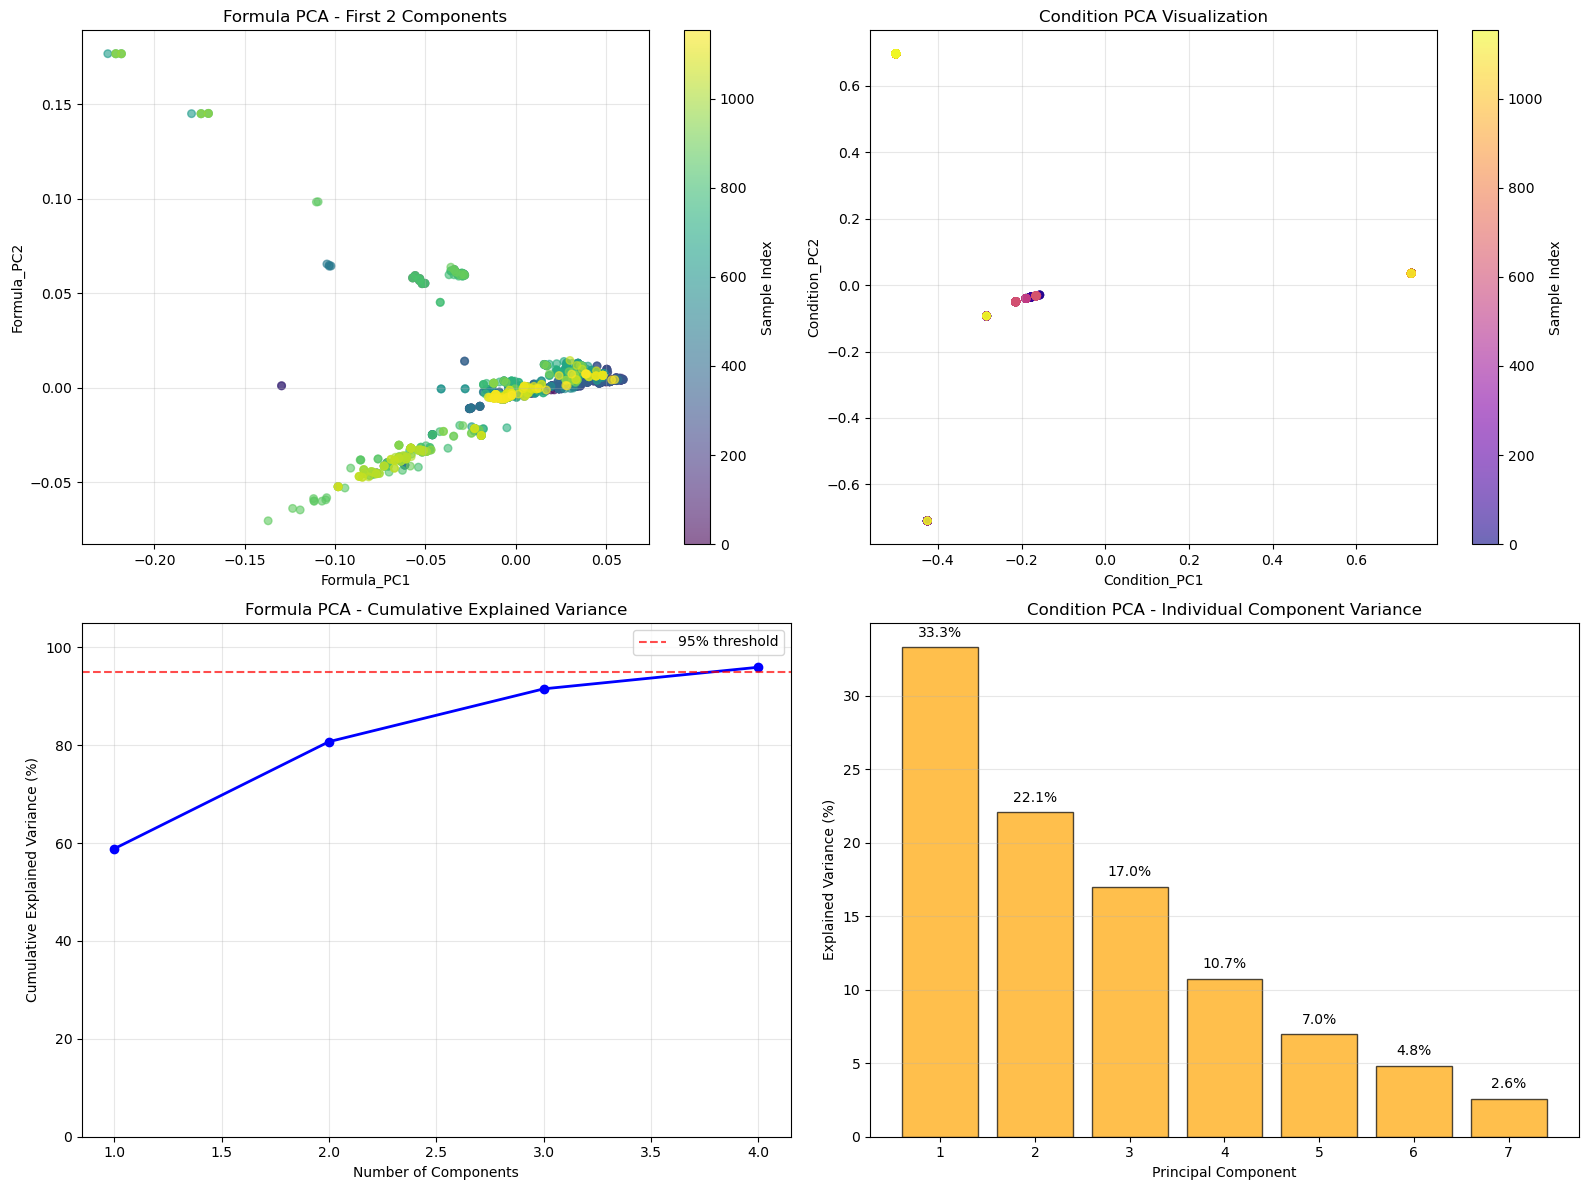

In [123]:
print("\nCreating visualizations...")

# Create a comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Formula PCA scatter plot (first 2 components)
if not formula_pca_df.empty and formula_pca_df.shape[1] >= 2:
    scatter1 = axes[0, 0].scatter(
        formula_pca_df.iloc[:, 0], formula_pca_df.iloc[:, 1], 
        alpha=0.6, s=30, c=range(len(formula_pca_df)), cmap='viridis'
    )
    axes[0, 0].set_xlabel(f'{formula_pca_df.columns[0]}')
    axes[0, 0].set_ylabel(f'{formula_pca_df.columns[1]}')
    axes[0, 0].set_title('Formula PCA - First 2 Components')
    axes[0, 0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0, 0], label='Sample Index')
else:
    axes[0, 0].text(0.5, 0.5, 'Formula PCA\nNot Available', 
                    ha='center', va='center', transform=axes[0, 0].transAxes)
    axes[0, 0].set_title('Formula PCA - Not Available')

# 2. Condition PCA visualization
if not condition_pca_df.empty:
    if condition_pca_df.shape[1] >= 2:
        scatter2 = axes[0, 1].scatter(
            condition_pca_df.iloc[:, 0], condition_pca_df.iloc[:, 1], 
            alpha=0.6, s=30, c=range(len(condition_pca_df)), cmap='plasma'
        )
        axes[0, 1].set_xlabel(f'{condition_pca_df.columns[0]}')
        axes[0, 1].set_ylabel(f'{condition_pca_df.columns[1]}')
        plt.colorbar(scatter2, ax=axes[0, 1], label='Sample Index')
    else:
        axes[0, 1].hist(condition_pca_df.iloc[:, 0], bins=50, alpha=0.7, color='orange')
        axes[0, 1].set_xlabel(f'{condition_pca_df.columns[0]}')
        axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Condition PCA Visualization')
    axes[0, 1].grid(True, alpha=0.3)
else:
    axes[0, 1].text(0.5, 0.5, 'Condition PCA\nNot Available', 
                    ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('Condition PCA - Not Available')

# 3. Formula PCA explained variance
if pca_formula is not None:
    cumvar_formula = np.cumsum(pca_formula.explained_variance_ratio_) * 100
    axes[1, 0].plot(range(1, len(cumvar_formula) + 1), cumvar_formula, 'b-', linewidth=2, marker='o')
    axes[1, 0].axhline(y=95, color='r', linestyle='--', alpha=0.7, label='95% threshold')
    axes[1, 0].set_xlabel('Number of Components')
    axes[1, 0].set_ylabel('Cumulative Explained Variance (%)')
    axes[1, 0].set_title('Formula PCA - Cumulative Explained Variance')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()
    axes[1, 0].set_ylim([0, 105])
else:
    axes[1, 0].text(0.5, 0.5, 'No Formula PCA\nData Available', 
                    ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Formula PCA - Variance Explanation')

# 4. Condition PCA explained variance
if pca_condition is not None and len(pca_condition.explained_variance_ratio_) > 1:
    bars = axes[1, 1].bar(range(1, len(pca_condition.explained_variance_ratio_) + 1),
                         pca_condition.explained_variance_ratio_ * 100, 
                         color='orange', alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Principal Component')
    axes[1, 1].set_ylabel('Explained Variance (%)')
    axes[1, 1].set_title('Condition PCA - Individual Component Variance')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{height:.1f}%', ha='center', va='bottom')
else:
    axes[1, 1].text(0.5, 0.5, f'Condition PCA\nSingle Component\n{pca_condition.explained_variance_ratio_[0]*100:.1f}% variance' if pca_condition is not None else 'No Condition PCA', 
                    ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Condition PCA - Variance Explanation')

plt.tight_layout()
plt.savefig('pca_analysis_results.png', dpi=300, bbox_inches='tight')
plt.show()

# 10. Combine All Data


In [124]:
print("\nCombining all processed data...")

# Start with ID and property columns
processed_data = data[['FID'] + property_cols].copy()

print(f"Base data shape (ID + Properties): {processed_data.shape}")

# Add formula PCA components
if not formula_pca_df.empty:
    processed_data = pd.concat([processed_data, formula_pca_df], axis=1)
    print(f"After adding formula PCA: {processed_data.shape}")

# Add condition PCA components
if not condition_pca_df.empty:
    processed_data = pd.concat([processed_data, condition_pca_df], axis=1)
    print(f"After adding condition PCA: {processed_data.shape}")

print(f"\nFinal processed data shape: {processed_data.shape}")
print(f"Memory usage: {processed_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display column summary
print(f"\nColumn summary:")
print(f"  ID column: 1")
print(f"  Property columns: {len(property_cols)}")
print(f"  Formula PCA components: {formula_pca_df.shape[1] if not formula_pca_df.empty else 0}")
print(f"  Condition PCA components: {condition_pca_df.shape[1] if not condition_pca_df.empty else 0}")


Combining all processed data...
Base data shape (ID + Properties): (1154, 4)
After adding formula PCA: (1154, 8)
After adding condition PCA: (1154, 15)

Final processed data shape: (1154, 15)
Memory usage: 0.13 MB

Column summary:
  ID column: 1
  Property columns: 3
  Formula PCA components: 4
  Condition PCA components: 7


# 11. Data Quality Assessment


In [125]:
print("\nData quality assessment...")

# Check for remaining missing values
missing_summary = processed_data.isnull().sum()
print(f"Missing values by column type:")
print(f"  Property columns: {missing_summary[property_cols].sum()}")
print(f"  Formula PCA columns: {missing_summary[formula_pca_df.columns].sum() if not formula_pca_df.empty else 0}")
print(f"  Condition PCA columns: {missing_summary[condition_pca_df.columns].sum() if not condition_pca_df.empty else 0}")

# Basic statistics for different column types
print(f"\nBasic statistics:")
if property_cols:
    print(f"Property columns statistics:")
    print(processed_data[property_cols].describe().round(3))

if not formula_pca_df.empty:
    print(f"\nFormula PCA components statistics:")
    print(processed_data[formula_pca_df.columns].describe().round(3))

if not condition_pca_df.empty:
    print(f"\nCondition PCA components statistics:")
    print(processed_data[condition_pca_df.columns].describe().round(3))


Data quality assessment...
Missing values by column type:
  Property columns: 250
  Formula PCA columns: 0
  Condition PCA columns: 0

Basic statistics:
Property columns statistics:
       Elongation (%)  Tensile Strength (MPa)  Yield Strength (MPa)
count        1046.000                1121.000              1045.000
mean           12.144                 344.482               281.872
std             7.322                 150.925               149.694
min             0.500                  44.816                10.342
25%             7.000                 220.632               163.200
50%            11.000                 324.054               260.000
75%            15.350                 468.500               393.001
max            50.000                 820.000               790.000

Formula PCA components statistics:
       Formula_PC1  Formula_PC2  Formula_PC3  Formula_PC4
count     1154.000     1154.000     1154.000     1154.000
mean         0.000       -0.000       -0.000        0

# 12. Propeties data preprocessing

Handling outliers in property columns...
  Elongation (%): 0 outliers (0.0%) capped to [-5.525, 27.875]
  Tensile Strength (MPa): 0 outliers (0.0%) capped to [-151.169, 840.302]
  Yield Strength (MPa): 0 outliers (0.0%) capped to [-181.502, 737.703]


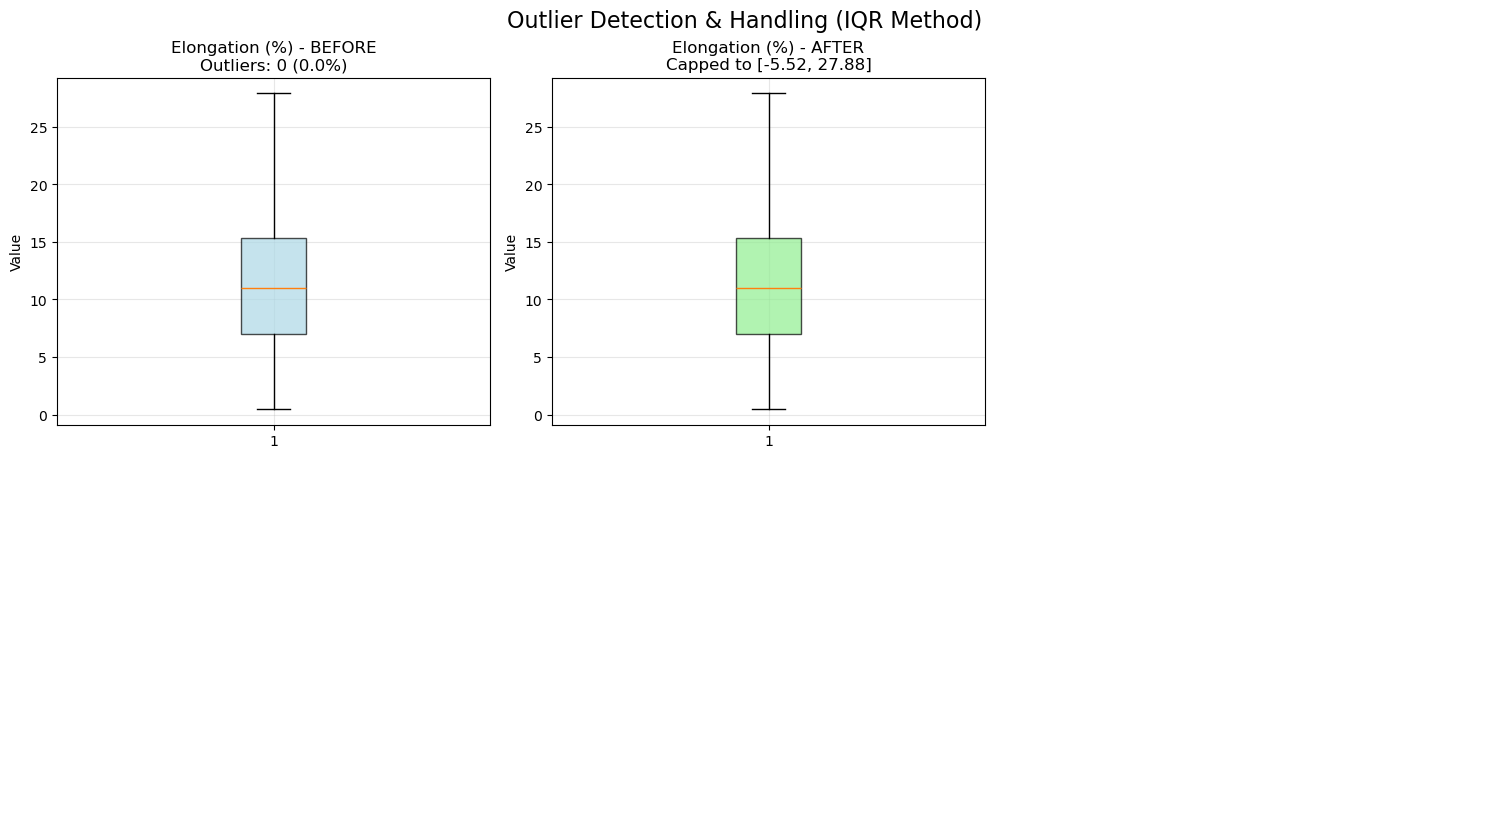

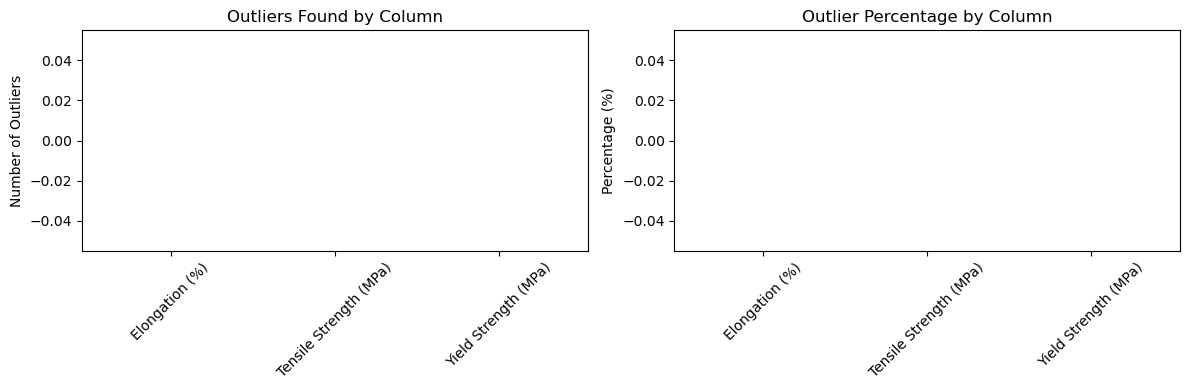


OUTLIER HANDLING SUMMARY
Column               Outliers   Percentage   Action
------------------------------------------------------------
Elongation (%)       0          0.0        % Capped
Tensile Strength (MPa) 0          0.0        % Capped
Yield Strength (MPa) 0          0.0        % Capped
------------------------------------------------------------
Total outliers handled: 0


In [127]:
print("Handling outliers in property columns...")

# Store outlier information for summary
outlier_info = {}

# Calculate subplot layout
valid_cols = [col for col in property_cols if col in data.columns]
n_cols = len(valid_cols)
n_rows = (n_cols + 2) // 3  # 3 plots per row

# Create figure for before/after comparison
fig, axes = plt.subplots(n_rows * 2, 3, figsize=(15, 4 * n_rows * 2))
if n_rows == 1:
    axes = axes.reshape(2, 3)
elif n_rows * 2 == 1:
    axes = axes.reshape(1, -1)

plot_idx = 0

for col in property_cols:
    if col not in processed_data.columns:
        continue
    
    # Store original data
    original_data = processed_data[col].copy()
    
    # Calculate IQR bounds
    Q1 = processed_data[col].quantile(0.25)
    Q3 = processed_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers
    outliers_mask = (processed_data[col] < lower_bound) | (processed_data[col] > upper_bound)
    n_outliers = outliers_mask.sum()
    outlier_percentage = (n_outliers / len(processed_data[col].dropna())) * 100
    
    # Store info
    outlier_info[col] = {
        'count': n_outliers,
        'percentage': outlier_percentage,
        'bounds': (lower_bound, upper_bound)
    }
    
    # Plot BEFORE (top row)
    if plot_idx < len(axes):
        ax = axes.flat[plot_idx]
        
        # Box plot with outliers highlighted
        bp = ax.boxplot(original_data.dropna(), patch_artist=True)
        bp['boxes'][0].set_facecolor('lightblue')
        bp['boxes'][0].set_alpha(0.7)
        
        # Highlight outliers
        outlier_values = original_data[outliers_mask]
        if len(outlier_values) > 0:
            ax.scatter([1] * len(outlier_values), outlier_values, 
                      color='red', alpha=0.6, s=30, label=f'Outliers: {n_outliers}')
            ax.legend()
        
        ax.set_title(f'{col} - BEFORE\nOutliers: {n_outliers} ({outlier_percentage:.1f}%)')
        ax.set_ylabel('Value')
        ax.grid(True, alpha=0.3)
        
        plot_idx += 1
    
    # Cap outliers
    processed_data[col] = np.where(processed_data[col] < lower_bound, lower_bound,
                                   np.where(processed_data[col] > upper_bound, upper_bound,
                                            processed_data[col]))
    
    # Plot AFTER (bottom row)
    if plot_idx < len(axes):
        ax = axes.flat[plot_idx]
        
        bp = ax.boxplot(processed_data[col].dropna(), patch_artist=True)
        bp['boxes'][0].set_facecolor('lightgreen')
        bp['boxes'][0].set_alpha(0.7)
        
        ax.set_title(f'{col} - AFTER\nCapped to [{lower_bound:.2f}, {upper_bound:.2f}]')
        ax.set_ylabel('Value')
        ax.grid(True, alpha=0.3)
        
        plot_idx += 1
    
    # Print summary
    print(f"  {col}: {n_outliers} outliers ({outlier_percentage:.1f}%) capped to [{lower_bound:.3f}, {upper_bound:.3f}]")

# Hide unused subplots
for i in range(plot_idx, len(axes.flat)):
    axes.flat[i].axis('off')

plt.tight_layout()
plt.suptitle('Outlier Detection & Handling (IQR Method)', fontsize=16, y=1.02)
plt.show()

# Summary visualization
if outlier_info:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Outlier counts
    cols = list(outlier_info.keys())
    counts = [info['count'] for info in outlier_info.values()]
    percentages = [info['percentage'] for info in outlier_info.values()]
    
    # Bar plot of counts
    bars1 = ax1.bar(cols, counts, color='coral', alpha=0.7)
    ax1.set_title('Outliers Found by Column')
    ax1.set_ylabel('Number of Outliers')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add labels
    for bar, count in zip(bars1, counts):
        if count > 0:
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                    f'{int(count)}', ha='center', va='bottom')
    
    # Bar plot of percentages
    bars2 = ax2.bar(cols, percentages, color='skyblue', alpha=0.7)
    ax2.set_title('Outlier Percentage by Column')
    ax2.set_ylabel('Percentage (%)')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add labels
    for bar, pct in zip(bars2, percentages):
        if pct > 0:
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(percentages)*0.01,
                    f'{pct:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    # save
    plt.savefig('outlier_handling_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

# Print final summary
print(f"\n{'='*60}")
print(f"OUTLIER HANDLING SUMMARY")
print(f"{'='*60}")
print(f"{'Column':<20} {'Outliers':<10} {'Percentage':<12} {'Action'}")
print(f"{'-'*60}")

total_outliers = 0
for col, info in outlier_info.items():
    total_outliers += info['count']
    print(f"{col:<20} {info['count']:<10} {info['percentage']:<11.1f}% Capped")

print(f"{'-'*60}")
print(f"Total outliers handled: {total_outliers}")
print(f"{'='*60}")

In [128]:
# for each property column, scale to [0, 1] range
print("\nScaling property columns to [0, 1] range...")
for col in property_cols:
    if col in processed_data.columns:
        min_val = processed_data[col].min()
        max_val = processed_data[col].max()
        if max_val > min_val:  # Avoid division by zero
            processed_data[col] = (processed_data[col] - min_val) / (max_val - min_val)
        else:
            processed_data[col] = 0.0  # If all values are the same, set to 0.0
        print(f"  {col}: min={min_val}, max={max_val}")
            
            


Scaling property columns to [0, 1] range...
  Elongation (%): min=0.5, max=27.875
  Tensile Strength (MPa): min=44.8159205, max=820.0
  Yield Strength (MPa): min=10.3421355, max=737.7028725


# 12. Save Results

In [129]:
print("\nSaving results...")

# Save processed data, where property columns replace as ["Property_1", "Property_2", ...], and "配方ID" renames to "FID"
output_path = 'processed_formula_property_data.csv'
processed_data.to_csv(output_path, index=False)
print(f"Processed data saved to: {output_path}")
# save a sample data
sample_path = 'sample_processed_rubber_data.csv'
processed_data.sample(n=100, random_state=42).to_csv(sample_path, index=False)

# Create and save detailed summary report
report_path = output_path.replace('.csv', '_processing_report.txt')
with open(report_path, 'w', encoding='utf-8') as f:
    f.write("RUBBER FORMULA DATA PROCESSING REPORT\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Processing completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("DATASET SUMMARY\n")
    f.write("-" * 30 + "\n")
    f.write(f"Original data shape: {data.shape}\n")
    f.write(f"Processed data shape: {processed_data.shape}\n")
    f.write(f"Compression ratio: {processed_data.shape[1] / data.shape[1]:.3f}\n\n")
    
    f.write("COLUMN BREAKDOWN\n")
    f.write("-" * 30 + "\n")
    f.write(f"Property columns retained: {len(property_cols)}\n")
    f.write(f"Formula columns → PCA components: {len(formula_cols)} → {formula_pca_df.shape[1] if not formula_pca_df.empty else 0}\n")
    f.write(f"Condition columns → PCA components: {len(condition_cols)} → {condition_pca_df.shape[1] if not condition_pca_df.empty else 0}\n\n")
    
    if pca_formula is not None:
        f.write("FORMULA PCA DETAILS\n")
        f.write("-" * 30 + "\n")
        f.write(f"Explained variance ratio: {pca_formula.explained_variance_ratio_.sum():.4f}\n")
        f.write(f"Components needed for 95% variance: {formula_pca_df.shape[1]}\n\n")
    
    if pca_condition is not None:
        f.write("CONDITION PCA DETAILS\n")
        f.write("-" * 30 + "\n")
        f.write(f"Explained variance ratio: {pca_condition.explained_variance_ratio_.sum():.4f}\n")
        f.write(f"Component breakdown:\n")
        for i, var_ratio in enumerate(pca_condition.explained_variance_ratio_):
            f.write(f"  PC{i+1}: {var_ratio:.4f}\n")
        f.write("\n")
    
    f.write("RETAINED PROPERTY COLUMNS\n")
    f.write("-" * 30 + "\n")
    for i, col in enumerate(property_cols, 1):
        f.write(f"{i:2d}. {col}\n")

print(f"Processing report saved to: {report_path}")

# Display final summary
print(f"\n" + "="*60)
print("PROCESSING COMPLETED SUCCESSFULLY")
print(f"="*60)
print(f"Original dataset: {data.shape[0]:,} rows × {data.shape[1]} columns")
print(f"Processed dataset: {processed_data.shape[0]:,} rows × {processed_data.shape[1]} columns")
print(f"Data reduction: {((data.shape[1] - processed_data.shape[1]) / data.shape[1] * 100):.1f}% fewer columns")
print(f"Files saved: {output_path}, {report_path}")


Saving results...
Processed data saved to: processed_formula_property_data.csv
Processing report saved to: processed_formula_property_data_processing_report.txt

PROCESSING COMPLETED SUCCESSFULLY
Original dataset: 1,154 rows × 39 columns
Processed dataset: 1,154 rows × 15 columns
Data reduction: 61.5% fewer columns
Files saved: processed_formula_property_data.csv, processed_formula_property_data_processing_report.txt
